In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_parquet('train-00000-of-00001-daf190ce720b3dbb.parquet', engine='pyarrow')
test = pd.read_parquet('test-00000-of-00001-fa9b3e8ade89a333.parquet', engine='pyarrow')
df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam
...,...,...
10895,Is it good and usable?\n\n[https://www.uscompa...,not_spam
10896,I'm not sure if this is the absolute best sub ...,not_spam
10897,Would love if anyone knew of any really good d...,not_spam
10898,"Fields = Hashrate, VRAM, TDP, MSRP, Profit/day",not_spam


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10900 non-null  object
 1   label   10900 non-null  object
dtypes: object(2)
memory usage: 170.4+ KB


,text,label
count,10900,10900
unique,10662,2
top,"Show off, complain, and generally have a chat ...",spam
freq,14,5500


In [4]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10662 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10662 non-null  object
 1   label   10662 non-null  object
dtypes: object(2)
memory usage: 249.9+ KB


In [5]:
df['label'].value_counts()

label
spam        5500
not_spam    5162
Name: count, dtype: int64

# EDA

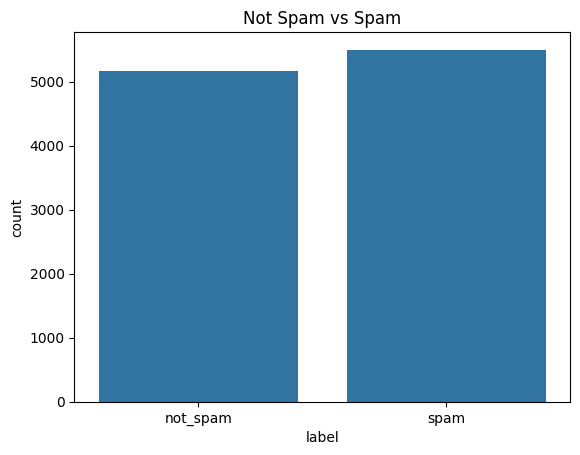

In [14]:
sns.countplot(data=df, x='label')
plt.title('Not Spam vs Spam')
plt.show()

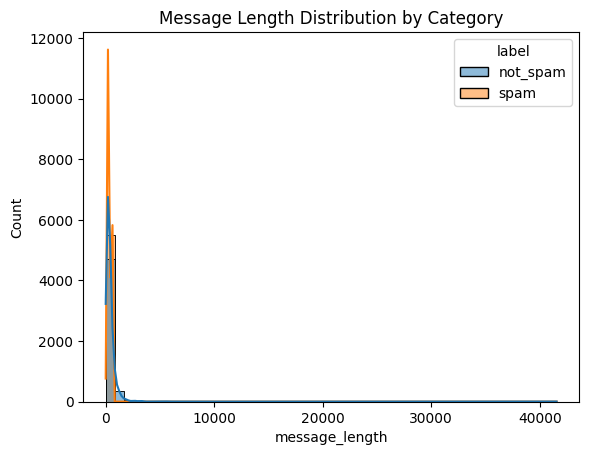

In [15]:
df['message_length'] = df['text'].apply(len)

# Plotting distribution of message lengths
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution by Category")
plt.show()

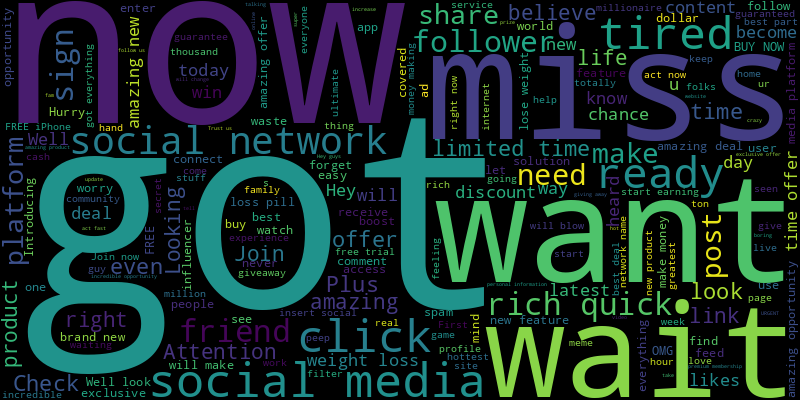

In [16]:
from wordcloud import WordCloud

spam_words = ' '.join(df[df['label'] == 'spam']['text'])
ham_words = ' '.join(df[df['label'] == 'not_spam']['text'])

# Spam WordCloud
WordCloud(width=800, height=400).generate(spam_words).to_image()

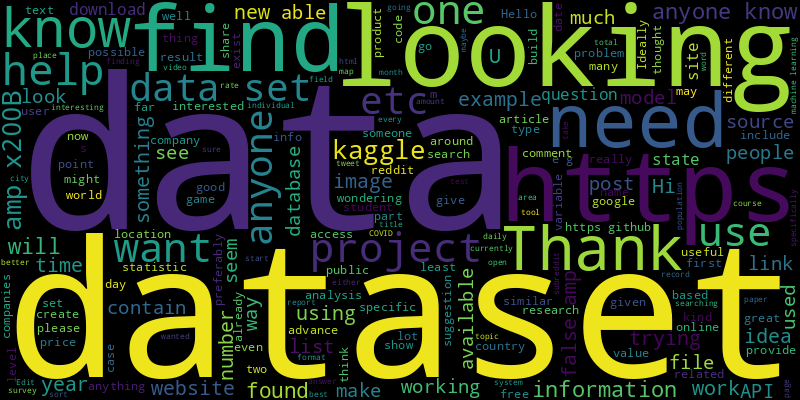

In [17]:
# Ham WordCloud
WordCloud(width=800, height=400).generate(ham_words).to_image()

# Feature Engineering

In [6]:
import re
from sklearn.model_selection import train_test_split

In [7]:
# Clean text
def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return text

df['clean_message'] = df['text'].apply(clean_text)

# Label Encoding
df['label'] = df['label'].map({'not_spam': 0, 'spam': 1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

/tmp/ipykernel_71723/2123172587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_message'] = df['text'].apply(clean_text)
/tmp/ipykernel_71723/2123172587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'not_spam': 0, 'spam': 1})


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [12]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9967182372245663
F1 Score:  0.9968109339407745
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   6 1094]]


In [34]:
svc = LinearSVC()
svc.fit(X_train_vec, y_train)

# Predict
y_pred = svc.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9971870604781997
F1 Score:  0.9972677595628415
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   5 1095]]


# Cross Validation

In [14]:
from sklearn.model_selection import cross_val_score

In [16]:
scores = cross_val_score(LogisticRegression(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: %f" % (scores.mean()))

Random Forest CV Accuracy: 0.996365


In [35]:
scores = cross_val_score(LinearSVC(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: %f" % (scores.mean()))

Random Forest CV Accuracy: 0.997538


# Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

In [39]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'penalty': ['l1', 'l2'],                # Regularization type
    'solver': ['liblinear', 'saga']         # Solvers that support l1/l2
}

lr = LogisticRegression(max_iter=10000, random_state=42)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.997655196597828


In [40]:
y_pred_rf = grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9976558837318331
F1 Score:  0.9977241693218024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   4 1096]]


In [42]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' only with 'liblinear' dual=False
    'dual': [False, True]
}

svc = LinearSVC()
svc_grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
svc_grid.fit(X_train_vec, y_train)

print("Best Parameters:", svc_grid.best_params_)
print("Best Score:", svc_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Li

Best Parameters: {'C': 1, 'dual': False, 'penalty': 'l2'}
Best Score: 0.9975378945450419


In [43]:
y_pred_rf = svc_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9971870604781997
F1 Score:  0.9972677595628415
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1032    1]
 [   5 1095]]


# Save

In [ ]:
import joblib

joblib.dump(grid, 'logistic_regression_model.pkl')
joblib.dump(svc_grid, 'svc_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Exception ignored in: <function ResourceTracker.__del__ at 0x7f670e651300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fcaa0651300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f2d25441300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

In [32]:
# Load models
lr_loaded = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example usage
text = """Dear Sir,

Please be aware of appointment on 05/13/2025."""
X_new = vectorizer.transform([text])
prediction = lr_loaded.predict(X_new)
print(prediction)

[0]
